In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.base import clone
from decision_tree import *
from ga_methods import ga_iteration
from tqdm import tqdm
from sklearn import tree

# data = load_digits()
# data = load_breast_cancer()
# data = load_iris()
# X = data.data
# y = data.target
df = pd.read_csv('abalone.csv')
df['Sex'] = df['Sex'].apply(lambda x: 0 if 'M' else 1)
labels = []
for r in df['Rings']:
    if 0<=r and r<=7:
        label = 1
    elif 8<=r and r<=10:
        label = 2
    elif 11<=r and r<=15:
        label = 3
    elif r>15:
        label = 4
    labels.append(label)
X = np.asarray(df.loc[:, df.columns!='Rings'])
y = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
p = 200     # number of hypotheses
r = 0.93    # fraction of crossover
m = 0.005   # mutation rate
step = 200  # number of steps
x = 1000    # size factor
gen_gap = 0.25 # generation gap
n_crossover = int(r*p)
assert n_crossover%2==0, "Odd n_crossover"
n_select = p - n_crossover
n_mutate = int(m*p)
print(f"Select {n_select} | Crossover {n_crossover} | Mutate {n_mutate}")

(3341, 8) (836, 8)
(array([1, 2, 3, 4]), array([ 672, 1509,  948,  212]))
(array([1, 2, 3, 4]), array([167, 382, 238,  49]))
Select 14 | Crossover 186 | Mutate 1


In [29]:
# generate initial population
def gen_new_binary_tree(X, y):
    new_tree = DecisionTree()
    new_tree.get_feature_range(X)
    feature = random.randrange(X.shape[-1])
    feature_range = new_tree.get_feature_range(X)[feature]
    threshold = random.uniform(feature_range[0], feature_range[1])
    left_value = random.choice(np.unique(y))
    right_value = left_value
    while right_value == left_value:
        right_value = random.choice(np.unique(y))
    new_tree.root = DecisionNode(feature=feature,
                                 threshold=threshold,
                                 value=None,
                                 parent=None)
    left_node = DecisionNode(feature=None,
                             threshold=None,
                             value=left_value,
                             parent=new_tree.root,
                             left=None,
                             right=None)
    right_node = DecisionNode(feature=None,
                              threshold=None,
                              value=right_value,
                              parent=new_tree.root,
                              left=None,
                              right=None)
    new_tree.root.left = left_node
    new_tree.root.right = right_node
    new_tree.setup_tree(X)
    return new_tree
trees = []
for i in range(p):
    new_tree = gen_new_binary_tree(X_train, y_train)
    trees.append(new_tree)

In [30]:
# keep accuracy of nodes
def eval_tree(tree, X, y):
    # clean accuracy log for nodes
    for node in tree.node_list:
        node.correct = 0
        node.incorrect = 0
    y_preds = []
    correct = 0
    y_pred = tree.predict_save_info(X, y)
    acc = correct/len(y)
    return acc

# scaled payoff function
def get_tree_scaled_payoff(index, tree_list, X, y, x):
    tree = tree_list[index]
    acc = eval_tree(tree, X, y)
    size = tree.get_size()
    payoff = (acc**2)*(x/(size**2+x))
    diff = 0
    for i, other_tree in enumerate(tree_list):
        if i == index:
            n_node_diff = abs(tree.get_size() - other_tree.get_size())
            tree_depth = tree.get_depth()
            n_level_diff = abs(tree_depth - other_tree.get_depth())
            diff += n_node_diff/(2*len(tree.node_list)) + n_level_diff/(2*tree_depth)
        else:
            continue
    mean_diff = diff/(len(tree_list) - 1)
    scaled_payoff = payoff*mean_diff
    return scaled_payoff

In [31]:
def crossover(tree1, tree2):
    # select nodes
    node_inacc1 = [node.incorrect/(node.correct + node.incorrect + 1e-7) for node in tree1.node_list]
    node_inacc2 = [node.incorrect/(node.correct + node.incorrect + 1e-7) for node in tree2.node_list]
    index1 = random.choices(range(len(tree1.node_list)), weights=node_inacc1)[0]
    node1 = tree1.node_list[index1]
    index2 = random.choices(range(len(tree2.node_list)), weights=node_inacc2)[0]
    node2 = tree2.node_list[index2]
    # swap subtrees
    # update parent
    parent1, parent2 = node1.parent, node2.parent
    node1.parent, node2.parent = parent2, parent1
    # update child
    if parent1 is not None:
        if parent1.left==node1:
            parent1.left = node2
        else:
            parent1.right = node2
    else:
        tree1.root = node2
    if parent2 is not None:
        if parent2.left==node2:
            parent2.left = node1
        else:
            parent2.right = node1
    else:
        tree2.root = node1
    # update trees and node_dicts
    tree1.node_list = tree1.get_node_list(tree1.root, [])
    tree2.node_list = tree2.get_node_list(tree2.root, [])
    return tree1, tree2

def mutate(tree):
    # node_list: dictionary of nodes
    # feature_range: list of n_features tuples (min_feat, max_feat)
    node_inacc = [node.incorrect/(node.correct + node.incorrect + 1e-7) for node in tree.node_list]
    node = random.choices(tree.node_list, weights=node_inacc)[0]
    # case split node
    if node.feature is not None:
        node_feature_range = tree.feature_range[node.feature]
        min_feat, max_feat = node_feature_range[0], node_feature_range[1]
        node.threshold = random.uniform(min_feat, max_feat)
    else:
        node.value = random.choice(tree.target_values)

Decision tree max depth 3 accuracy:  0.562200956937799
Decision tree size:  15


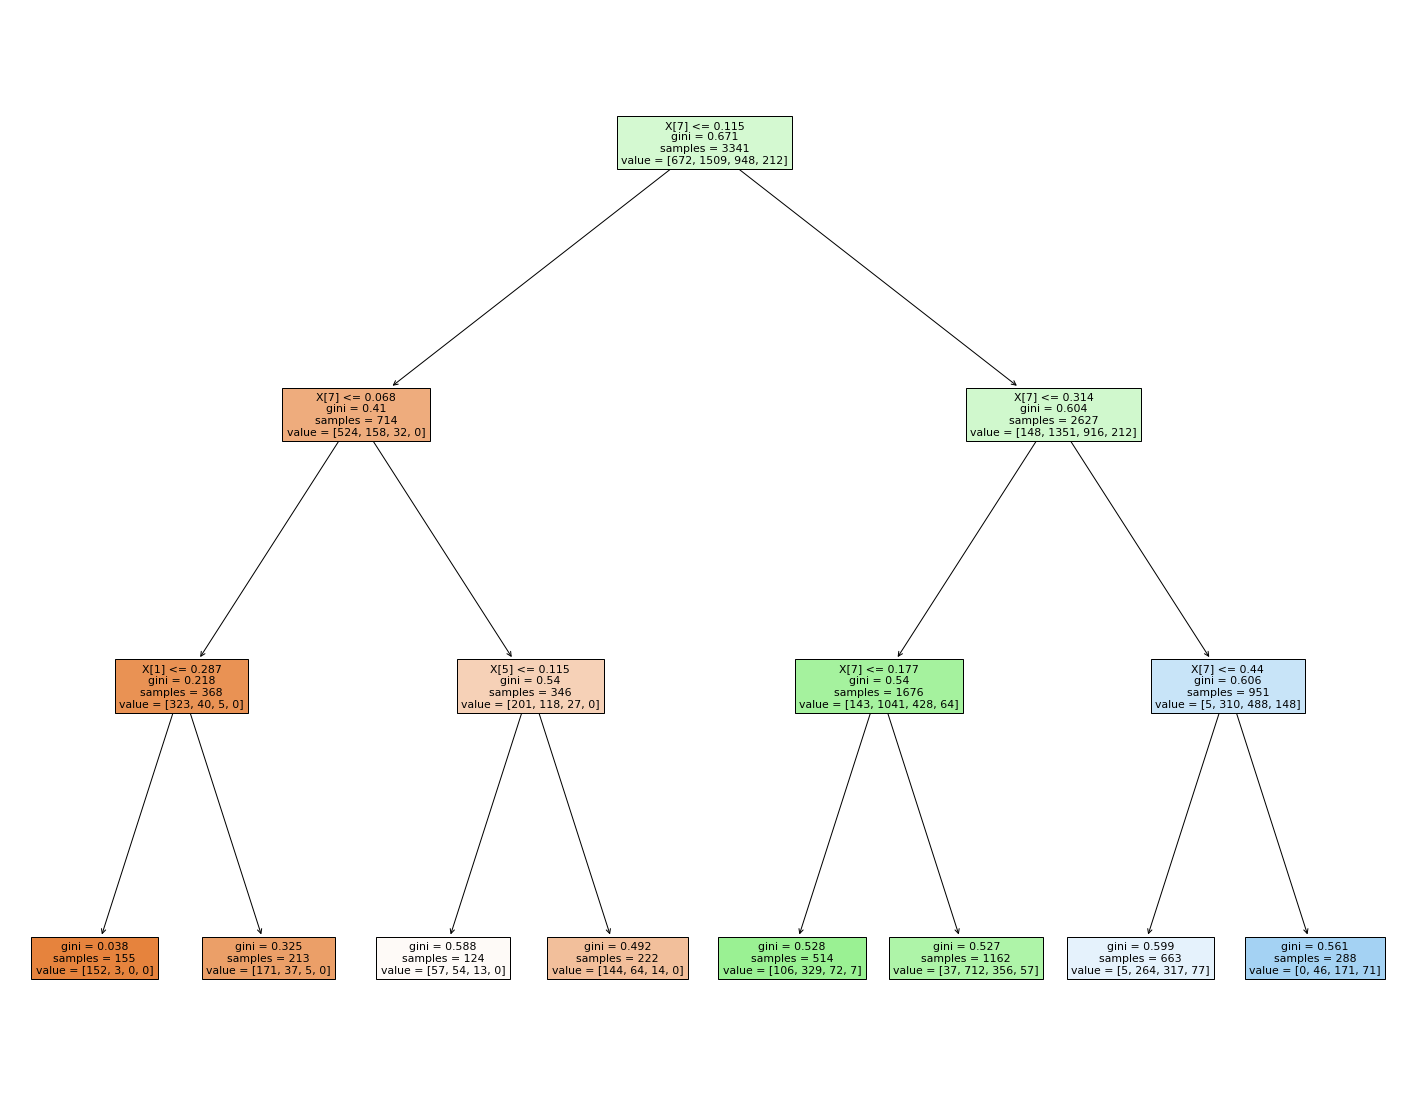

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print('Decision tree max depth 3 accuracy: ', eval_model(clf, X_test, y_test))
print('Decision tree size: ', clf.tree_.node_count)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   filled=True)

In [35]:
clf = BaggingClassifier()
clf.fit(X_train, y_train)
print('Bagging accuracy: ', eval_model(clf, X_test, y_test))

Bagging accuracy:  0.5813397129186603


In [36]:
# genetic algorithm with overlapping generations
best_acc = 0
for i in range(step):
    # evaluate trees
    scaled_payoffs = []
    for j in range(len(trees)):
        scaled_payoffs.append(get_tree_scaled_payoff(j, trees, X_train, y_train, x))
    # replace 25% worst trees
    payoff_threshold = np.quantile(scaled_payoffs, gen_gap)
    for j, scaled_payoff in enumerate(scaled_payoffs):
        if scaled_payoff <= payoff_threshold:
            tree = gen_new_binary_tree(X_train, y_train)
            trees[j] = tree
            # update payoff
            scaled_payoffs[j] = get_tree_scaled_payoff(j, trees, X_train, y_train, x)
    next_gen_trees = []
    # select top
    select_indices = np.asarray(scaled_payoffs).argsort()[-n_select:][::-1]
    for j in select_indices:
        next_gen_trees.append(trees[j])

    # crossover
    crossover_trees = []
    select_indices = np.asarray(scaled_payoffs).argsort()[-n_crossover:][::-1]
    for j in select_indices:
        crossover_trees.append(trees[j])
    random.shuffle(crossover_trees)
    for j in range(0, len(crossover_trees), 2):
        tree1 = crossover_trees[j]
        tree2 = crossover_trees[j+1]
        new_tree1, new_tree2 = crossover(tree1, tree2)
        crossover_trees[j] = new_tree1
        crossover_trees[j+1] = new_tree2
    next_gen_trees.extend(crossover_trees)
    # mutate
    select_indices = random.sample(range(len(next_gen_trees)), n_mutate)
    for j in select_indices:
        try:
            mutate(next_gen_trees[j])
        except AttributeError as e:
            print(next_gen_trees[j].root.correct, next_gen_trees[j].root.incorrect)
            raise e
    # get acc
    iter_acc = [eval_model(tree, X_test, y_test) for tree in next_gen_trees]
    iter_depth = [tree.get_depth() for tree in next_gen_trees]
    iter_size = [tree.get_size() for tree in next_gen_trees]
    iter_df = pd.DataFrame({'acc': iter_acc, 'depth': iter_depth, 'size': iter_size, 'index': range(p)})
    top_5 = iter_df.nlargest(5, 'acc')
    print(f"Step {i}")
    print(f"Average top 5: acc {round(top_5['acc'].mean()*100, 2)} | depth {top_5['depth'].mean()} | size {top_5['size'].mean()}")
    print(f"Max acc: {round(top_5['acc'].max()*100, 2)}")
    def get_bagging_results(tree_list, X, y):
        results = []
        preds = bagging_predict(tree_list, X)
        return accuracy_score(y, preds)
    top_5_trees = [next_gen_trees[j] for j in top_5['index']]
    print(f"Bagging acc: {round(get_bagging_results(top_5_trees, X_test, y_test)*100, 2)}")
    
    trees = next_gen_trees[:]
    if best_acc < top_5['acc'].max():
        best_acc = top_5['acc'].max()
print(f"Best accuracy: {round(best_acc*100, 2)}")

Step 0
Average top 5: acc 49.26 | depth 2.6 | size 4.2
Max acc: 51.79
Bagging acc: 51.79
Step 1
Average top 5: acc 49.74 | depth 2.4 | size 3.8
Max acc: 52.39
Bagging acc: 51.56
Step 2
Average top 5: acc 53.37 | depth 2.2 | size 3.4
Max acc: 53.95
Bagging acc: 53.83
Step 3
Average top 5: acc 50.93 | depth 2.8 | size 4.6
Max acc: 53.59
Bagging acc: 52.27
Step 4
Average top 5: acc 47.82 | depth 2.2 | size 3.4
Max acc: 50.96
Bagging acc: 45.81
Step 5
Average top 5: acc 48.68 | depth 2.4 | size 3.8
Max acc: 49.76
Bagging acc: 49.28
Step 6
Average top 5: acc 46.2 | depth 2.0 | size 3.0
Max acc: 47.37
Bagging acc: 45.69
Step 7
Average top 5: acc 51.56 | depth 2.2 | size 3.4
Max acc: 52.99
Bagging acc: 52.27
Step 8
Average top 5: acc 48.61 | depth 2.4 | size 3.8
Max acc: 51.2
Bagging acc: 48.21
Step 9
Average top 5: acc 52.03 | depth 2.2 | size 3.4
Max acc: 52.99
Bagging acc: 52.75
Step 10
Average top 5: acc 48.95 | depth 2.6 | size 4.2
Max acc: 53.35
Bagging acc: 50.12
Step 11
Average top 5:

Step 92
Average top 5: acc 50.12 | depth 2.4 | size 3.8
Max acc: 53.95
Bagging acc: 48.09
Step 93
Average top 5: acc 47.54 | depth 2.2 | size 3.4
Max acc: 48.92
Bagging acc: 49.16
Step 94
Average top 5: acc 48.23 | depth 2.6 | size 4.2
Max acc: 53.71
Bagging acc: 46.05
Step 95
Average top 5: acc 48.52 | depth 2.2 | size 3.4
Max acc: 51.91
Bagging acc: 48.33
Step 96
Average top 5: acc 52.25 | depth 2.0 | size 3.0
Max acc: 53.83
Bagging acc: 52.87
Step 97
Average top 5: acc 47.37 | depth 2.8 | size 4.6
Max acc: 49.04
Bagging acc: 47.37
Step 98
Average top 5: acc 48.92 | depth 2.8 | size 4.6
Max acc: 51.79
Bagging acc: 47.37
Step 99
Average top 5: acc 46.77 | depth 2.4 | size 3.8
Max acc: 48.33
Bagging acc: 47.49
Step 100
Average top 5: acc 47.87 | depth 2.2 | size 3.4
Max acc: 50.36
Bagging acc: 46.53
Step 101
Average top 5: acc 51.46 | depth 2.2 | size 3.4
Max acc: 53.47
Bagging acc: 51.32
Step 102
Average top 5: acc 53.04 | depth 2.4 | size 3.8
Max acc: 53.83
Bagging acc: 53.71
Step 10

Step 183
Average top 5: acc 49.47 | depth 2.6 | size 4.2
Max acc: 51.79
Bagging acc: 51.08
Step 184
Average top 5: acc 47.22 | depth 2.0 | size 3.0
Max acc: 52.15
Bagging acc: 45.69
Step 185
Average top 5: acc 50.89 | depth 2.2 | size 3.4
Max acc: 52.39
Bagging acc: 51.91
Step 186
Average top 5: acc 48.59 | depth 2.6 | size 4.2
Max acc: 53.47
Bagging acc: 47.37
Step 187
Average top 5: acc 50.41 | depth 2.0 | size 3.0
Max acc: 53.23
Bagging acc: 50.72
Step 188
Average top 5: acc 50.62 | depth 2.4 | size 3.8
Max acc: 53.71
Bagging acc: 52.15
Step 189
Average top 5: acc 50.45 | depth 2.6 | size 4.2
Max acc: 54.78
Bagging acc: 53.71
Step 190
Average top 5: acc 50.19 | depth 2.6 | size 4.2
Max acc: 53.23
Bagging acc: 53.35
Step 191
Average top 5: acc 51.58 | depth 2.6 | size 4.2
Max acc: 52.15
Bagging acc: 51.67
Step 192
Average top 5: acc 49.21 | depth 2.4 | size 3.8
Max acc: 53.35
Bagging acc: 48.8
Step 193
Average top 5: acc 48.56 | depth 2.0 | size 3.0
Max acc: 54.19
Bagging acc: 46.05
